# 🩸 Blood Cell Type - Image Classification
---

Given *images of blood cells*, let's **classify** new images according to their **type of cell**.

# Getting Started

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report

In [18]:
train_directory = '../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN'
test_directory = '../input/blood-cells/dataset2-master/dataset2-master/images/TEST'

# Loading Image Data

Prevent running out of memory by using generators.

In [19]:
# Create generators
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [20]:
# Flow image data
train_images=train_generator.flow_from_directory(
    directory=train_directory,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images=train_generator.flow_from_directory(
    directory=train_directory,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images=test_generator.flow_from_directory(
    directory=test_directory,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 7968 images belonging to 4 classes.
Found 1989 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


# Build Pretrained Model

In [36]:
# Load pretrained model
pretrained_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# The convolutional layers have already been optimized to extract features
pretrained_model.trainable = False

In [22]:
pretrained_model.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [23]:
pretrained_model.output

<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d')>

# Build Classification Model

In [25]:
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training

In [26]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

2022-10-23 09:11:26.818911: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-10-23 09:11:31.745525: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


249/249 [==============================] - 82s 265ms/step - loss: 0.8366 - accuracy: 0.6574 - val_loss: 0.5707 - val_accuracy: 0.7783
Epoch 2/100
249/249 [==============================] - 38s 152ms/step - loss: 0.4667 - accuracy: 0.8230 - val_loss: 0.4403 - val_accuracy: 0.8331
Epoch 3/100
249/249 [==============================] - 33s 134ms/step - loss: 0.3513 - accuracy: 0.8657 - val_loss: 0.3811 - val_accuracy: 0.8426
Epoch 4/100
249/249 [==============================] - 34s 136ms/step - loss: 0.2803 - accuracy: 0.8972 - val_loss: 0.2974 - val_accuracy: 0.8849
Epoch 5/100
249/249 [==============================] - 35s 141ms/step - loss: 0.2043 - accuracy: 0.9305 - val_loss: 0.2535 - val_accuracy: 0.9060
Epoch 6/100
249/249 [==============================] - 34s 136ms/step - loss: 0.1803 - accuracy: 0.9360 - val_loss: 0.2712 - val_accuracy: 0.8949
Epoch 7/100
249/249 [==============================] - 34s 136ms/step - loss: 0.1357 - accuracy: 0.9578 - val_loss: 0.2231 - val_accurac

In [37]:
model.save('model.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



# Results

In [31]:
CLASS_NAMES = list(train_images.class_indices.keys())
CLASS_NAMES

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

Test Accuracy: 51.628 %


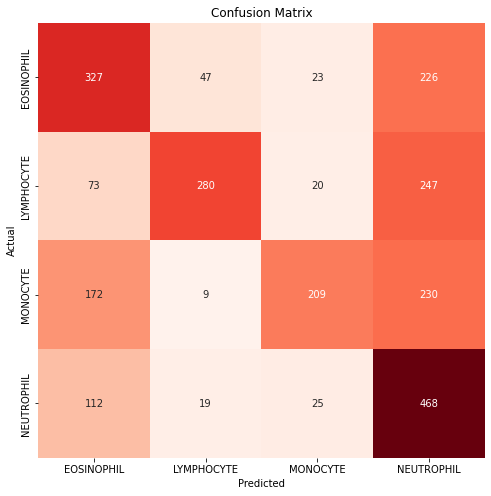

Classification Report:
-----------------------------
               precision    recall  f1-score   support

  EOSINOPHIL       0.48      0.52      0.50       623
  LYMPHOCYTE       0.79      0.45      0.57       620
    MONOCYTE       0.75      0.34      0.47       620
  NEUTROPHIL       0.40      0.75      0.52       624

    accuracy                           0.52      2487
   macro avg       0.61      0.52      0.52      2487
weighted avg       0.60      0.52      0.52      2487



In [35]:
predictions = np.argmax(model.predict(test_images), axis=1)

acc = accuracy_score(test_images.labels, predictions)
cm = tf.math.confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f} %".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Reds', cbar=False)
plt.xticks(ticks=np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks=np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n-----------------------------\n", clr)

Something is alarming in the results we got. The validation set has an accuracy of about 93% which is good. But on the test set, the accuracy drops to around 50%. This is not normal and it means that the test set is not similar to the train set. 